## Import Packages

In [15]:
def helper_display_img(image, title):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

In [2]:
import cv2
import numpy as np

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import requests

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

## Load Dataset

In [12]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalisasi nilai pixel
train_images, test_images = train_images / 255.0, test_images / 255.0

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [13]:
# Cek banyak data label untuk menentukan neuron pada OUTPUT layer
unique = np.unique(train_labels)
print(unique)

[0 1 2 3 4 5 6 7 8 9]


In [18]:
names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

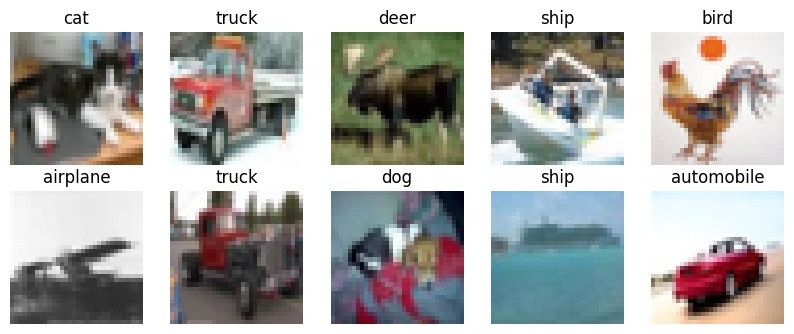

In [19]:
# DIsplay
random = np.random.randint(0, train_images.shape[0], 10)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    helper_display_img(train_images[random[i]], names[train_labels[random[i]][0]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

## Load Model Pretrained dan Setup Transfer Learning


In [8]:
# Define input shape explicitly using Input layer
input_tensor = layers.Input(shape=(32, 32, 3))

# Load MobileNetV2 tanpa lapisan output terakhir
base_model = MobileNetV2(input_tensor=input_tensor,
                         include_top=False,
                         weights='imagenet')

# Ubah lapisan-lapisan menjadi tidak dapat dilatih
base_model.trainable = False   # Freeze semua lapisan

base_model.summary()

<ipython-input-8-34a9ed251f87>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor,


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Tambahkan lapisan akhir untuk klasifikasi

In [10]:
# Tambahkan lapisan akhir untuk klasifikasi
x = base_model.output  # Get the output tensor of the base_model
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compiling dan Training Model

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,)

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=early_stopping)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 39ms/step - accuracy: 0.2446 - loss: 2.1370 - val_accuracy: 0.2950 - val_loss: 1.9626
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.3112 - loss: 1.9400 - val_accuracy: 0.3074 - val_loss: 1.9234
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.3192 - loss: 1.9044 - val_accuracy: 0.3078 - val_loss: 1.9089
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - accuracy: 0.3219 - loss: 1.8893 - val_accuracy: 0.3105 - val_loss: 1.9019
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.3218 - loss: 1.8817 - val_accuracy: 0.3142 - val_loss: 1.8976
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.3265 - loss: 1.8727 - val_accuracy: 0.3127 - val_loss: 1.8964
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.3254 - loss: 1.8765 - val_accuracy: 0.3142 - val_loss: 1.8955
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.3218 -

## Evaluasi Model

In [24]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

313/313 - 8s - 25ms/step - accuracy: 0.3185 - loss: 1.8936
Test accuracy: 0.31850001215934753


## Visualisasi Akurasi dan Loss

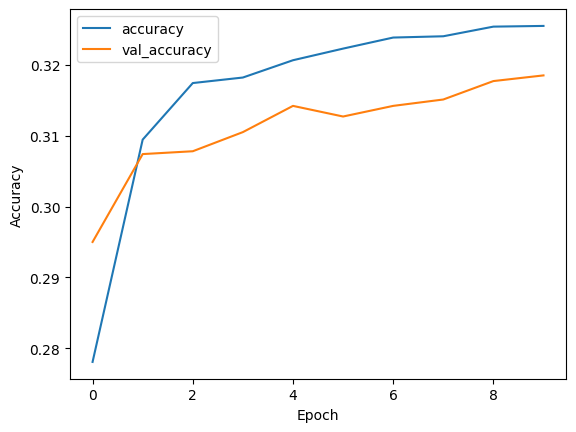

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Saving model

In [25]:
model.save('my_cifar10_model.keras')

## Predict with random image

In [26]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxYiL4_RDI2PcPw8-BxpwRJI_MDxigI0BlIA&s"

In [41]:
# Get the image from the URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Image resize
img_resize = cv2.resize(np.array(img), (32, 32))

# Image normalization
img_norm = img_resize / 255.0

#helper_display_img(img, 'Random Image')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


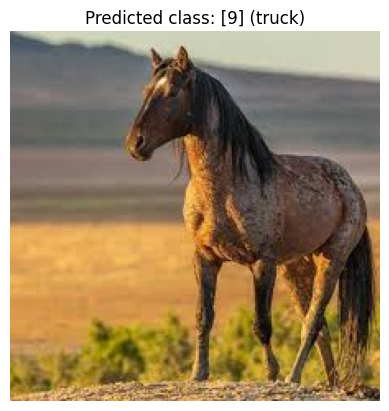

In [40]:
# Ubah ke 4d Tensor
img_4d = np.expand_dims(img_norm, axis=0)

# Predict
prediction = model.predict(img_4d)
label = np.argmax(prediction, axis=1)

# Print the predicted class
title = f"Predicted class: {label} ({names[label[0]]})"
helper_display_img(img, title)